### CUARTO PROYECTO CURSO DATA SCIENCE - ACAMICA
### Nombre : Sebastián Romero


### Sistemas de Recomendación para la plataforma Steam

Descargar el dataset [aquí](https://github.com/kang205/SASRec). Hay dos archivos, uno de calificaciones y otro de información sobre los juegos.

**Objetivo Principal:** 

Desarrollar diferentes tipos de sistemas de recomendación para el Dataset Steam y elegir el que presente un mejor desempeño.

**Objetivos específicos:**

* Desarrollar un análisis exploratorio exhaustivo del Dataset Steam que nos permita tomar las desiciones adecuadas para el preprocesamiento y así asegurar la uniformidad del conjunto de datos.
* Plantear diferentes alternativas para contruir un sistema de recomendación (caso benchmark, basado en contenidos y de filtro colaborativo basado en memoria y modelo), estructurarlas y desarrollarlas.
* Elegir una métrica de evaluación acorde a las caracteristicas del Dataset Steam, de feedback implícito, que permita evaluar tanto la presencia como la ubicación de un item relevante en una recomendación.
* Comparar los diferentes sistemas de recomendación desarrolados por medio de su desempeño en la métrica de evaluación elegida.
* Generar algunas predicciones como la recomendación para un usuario específico, entre otros, para el sistema de recomendación con mejor desempeño.

### Carga de los Datasets y preprocesamiento inicial 

El Dataset Steam consta de dos archivos, un Dataset Reviews que contiene la reseña que cada usuario ha hecho sobre un juego en especifico y algunos datos sobre la interacción entre dicho usuario y el juego en cuestión, y el Dataset Games que tiene toda la información sobre el contenido y características de los juegos.

Lo primero que haremos será importar las librerias ya comunmente usadas como numpy, pandas, matplotlib y seaborn, ademas que la libreria gzip que nos permitirá abrir los Datasets que se encuentran en formato json.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

pd.set_option('display.width', 150)

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

#### Carga de los Datasets Reviews y Games

In [3]:
data_reviews = []
for l in parse('steam_reviews.json.gz'):
    data_reviews.append(l)

In [4]:
data_reviews = pd.DataFrame(data_reviews)

In [5]:
data_reviews.head(3)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN


In [6]:
print('El Dataset Reviews cargado tiene dimensiones: ',data_reviews.shape)

El Dataset Reviews cargado tiene dimensiones:  (7793069, 12)


In [7]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)

In [8]:
data_games = pd.DataFrame(data_games)

In [9]:
data_games.head(3)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN


In [10]:
print('El Dataset Games cargado tiene dimensiones: ',data_games.shape)

El Dataset Games cargado tiene dimensiones:  (32135, 16)


#### Eliminación de columnas poco informativas 

Para el dataset Reviews, las columnas page_order, date, early_acces, page, compensation  y found_funny son meramente informativas dentro de la base de datos pero no aportan información determinante sobre el usuario o el producto, así que son eliminadas. La columna user_id tiene multiples valores faltantes por lo tanto es eliminada. Será necesario crear una nueva identificación numérica para los usuarios en la cual no existan valores faltantes, para poder desarrollar el sistema de recomendación posteriormente. La columna products no será de utilidad ya que nos interesa el número de juegos que cada usuario tiene dentro del dataset y products incluye entradas por fuera de este dataset, que es una fracción de un dataset mucho más grande.

In [11]:
data_reviews.drop(['page_order','date','early_access','page','found_funny','compensation','user_id','products'],
                  axis=1, inplace=True)

In [12]:
data_reviews.isna().sum()

username          0
hours         26537
product_id        0
text              0
dtype: int64

Las entradas que no cuentan con número de horas jugadas no nos son útiles para desarrollar el algoritmo de recomendación y por esta razón nos deshacemos de dichas entradas.

In [13]:
data_reviews.dropna(subset=['hours'], inplace=True)

Eliminaremos las entradas que contienen al usuario y al juego por duplicado, a pesar que las demás características sean diferentes. Esto puede deberse a que se tomaron los datos de un usuario jugando un mismo juego en diferentes momentos. En este caso nos quedaremos con el número de horas mayor, ya que esta será la variable determinante para definir la preferencia de un usuario por un juego, como veremos posteriormente.

In [14]:
max_horas = data_reviews.groupby(['username', 'product_id']).hours.transform(max)
data_reviews = data_reviews[data_reviews.hours == max_horas]

data_reviews.drop_duplicates(subset=['username','product_id'], inplace=True)

Eliminaremos del dataset reviews las reseñas que registran cero horas de juego.

In [15]:
data_reviews = data_reviews[data_reviews.hours != 0]

Para el dataset Games las columnas url, release_date, discount_price, reviews_url, early_access, sentiment y metascore, son eliminadas ya que no aportan información determinante para la identificación o comparación de los juegos. Las columna app_name y publisher se elimina ya que cuenta con la misma información que las columnas title y developer.

In [16]:
data_games.drop(['app_name','url','release_date','discount_price','reviews_url','early_access','metascore',
                 'publisher','sentiment'], axis=1, inplace=True)

In [17]:
data_games.isna().sum()

genres       3283
title        2050
tags          163
specs         670
price        1377
id              2
developer    3299
dtype: int64

Los juegos que no tienen título o identificación serán eliminados ya que no podemos recomendar juegos cuyo nombre desconocemos, además las identificaciones de juego duplicadas también serán eliminadas.

In [18]:
data_games.dropna(subset=['title','id'], inplace=True)

data_games.drop_duplicates(subset=['id'], inplace=True)

In [19]:
data_reviews = data_reviews.reset_index(drop = True)
print('El Dataset Reviews tiene dimensiones: ',data_reviews.shape)

El Dataset Reviews tiene dimensiones:  (6859848, 4)


In [20]:
data_games = data_games.reset_index(drop = True)
print('El Dataset Games tiene dimensiones: ',data_games.shape)

El Dataset Games tiene dimensiones:  (30083, 7)


### Análisis exploratorio y preprocesamiento de los datos

#### Dataset Reviews

#### Distribución de la variable 'hours'

Algunos estadísticos de la distribución de las horas de juego.

In [21]:
print('promedio : %0.2f' % (data_reviews.hours.mean()))
print('std :      %0.2f' % (data_reviews.hours.std()))
print('mínimo :   %0.2f' % (data_reviews.hours.min()))
print('Q1 :       %0.2f' % (data_reviews.hours.quantile(0.25)))
print('mediana :  %0.2f' % (data_reviews.hours.quantile(0.5)))
print('Q3 :       %0.2f' % (data_reviews.hours.quantile(0.75)))
print('máximo :   %0.2f' % (data_reviews.hours.max()))

promedio : 101.08
std :      373.83
mínimo :   0.10
Q1 :       3.60
mediana :  13.70
Q3 :       52.20
máximo :   42100.70


Observaremos la distribución del número de horas de juego con respecto a las reseñas totales. Utilizando esta distribución determinaremos el valor adecuado para el umbral del número de horas de juego que definirá posteriormente la preferencia de un usuario por un juego.

In [22]:
distribución_horas = data_reviews.hours.sort_values(ascending = True).values
conteo_reviews = np.arange(1,len(distribución_horas)+1)

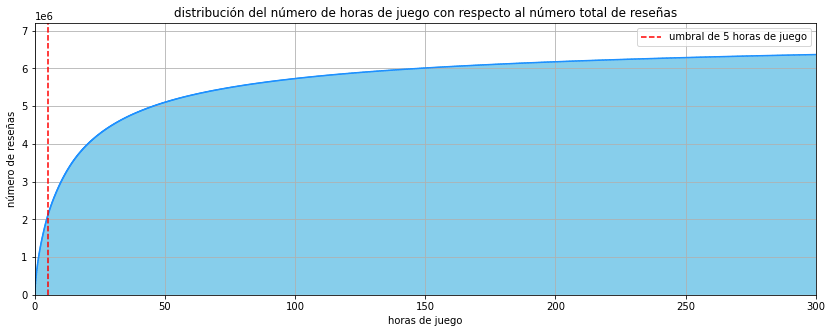

In [23]:
plt.figure(figsize=(14,5))
plt.title('distribución del número de horas de juego con respecto al número total de reseñas')
plt.plot(distribución_horas, conteo_reviews, color='dodgerblue')
plt.fill_between(distribución_horas, conteo_reviews, color='skyblue')
plt.axvline(x=5, c='r', ls='--', label='umbral de 5 horas de juego')
plt.xlabel('horas de juego')
plt.ylabel('número de reseñas')
plt.legend(loc=0)
plt.xlim(0,300)
plt.ylim(0)
plt.grid()
plt.show()

In [24]:
print('número de reseñas con 5 o más horas de juego : ', len(data_reviews[data_reviews.hours >= 5]))
print('número de reseñas con menos de 5 horas de juego : ', len(data_reviews[data_reviews.hours < 5]))

número de reseñas con 5 o más horas de juego :  4789783
número de reseñas con menos de 5 horas de juego :  2070065


A partir de la información obtenida se define el umbral de preferencia de un usuario por un juego en 5 horas de interacción.

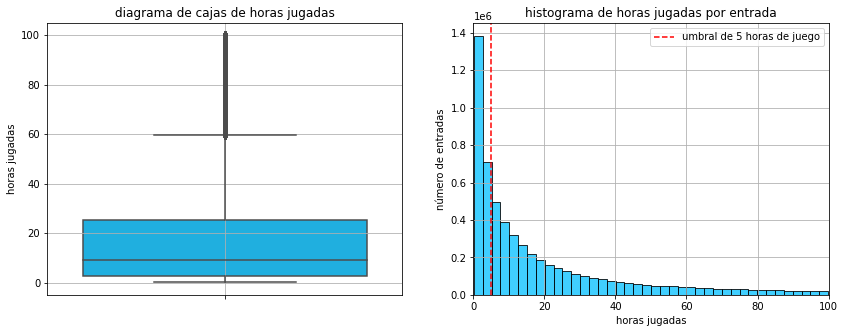

In [25]:
plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
max_hour = 100
sns.boxplot(y = data_reviews.hours[data_reviews.hours<max_hour], color='deepskyblue')
plt.title("diagrama de cajas de horas jugadas")
plt.ylabel("horas jugadas")
plt.grid()
plt.subplot(1,2,2)
sns.histplot(data = data_reviews.hours[data_reviews.hours<max_hour], bins = 40, color='deepskyblue')
plt.axvline(x=5, c='r', ls='--', label='umbral de 5 horas de juego')
plt.title("histograma de horas jugadas por entrada")
plt.xlabel("horas jugadas")
plt.ylabel("número de entradas")
plt.legend(loc=0)
plt.xlim(0,max_hour)
plt.grid()
plt.show()

El umbral de preferencia de un usuario por un juego es de suma importancia, ya que al tratarse de un dataset de feedback implícito, no se cuenta con una calificación explícita de un usuario con respecto a un juego (sea de su gusto o no); si no con una o varias variables que implicitamente reflejan la preferencia a través de la interacción entre el usuario y el juego. En este caso la variable que utilizamos es el número de horas de juego y el umbral que define la preferencia de un usuario por un juego es de 5 horas. 

En un sistema de recomendación implícito la preferencia es una variable binaria que toma los valores 1 (si hay preferencia) o 0 (si no la hay). Es por ello que las reseñas con menos de 5 horas de juego, al igual que todas las interacciones faltantes entre usuarios y juegos tomarán el valor de 0, por ello eliminaremos estas reseñas, ya que con las reseñas restantes construiremos la preferencia positiva.

In [26]:
data_reviews = data_reviews[data_reviews.hours >= 5]

In [27]:
data_reviews = data_reviews.reset_index(drop = True)
print('El Dataset Reviews tiene dimensiones: ',data_reviews.shape)

El Dataset Reviews tiene dimensiones:  (4789783, 4)


#### Distribución de la variable 'product_id'

In [28]:
print('el número de juegos existentes es : ', len(np.unique(data_reviews.product_id)))

el número de juegos existentes es :  12822


In [29]:
distribucion_juegos = data_reviews.product_id.value_counts()
print('número de jugadores por id de juego\n')
print(distribucion_juegos)

número de jugadores por id de juego

440       113443
252490     63144
49520      48450
377160     45703
301520     40636
           ...  
452000         1
643600         1
496390         1
708120         1
739210         1
Name: product_id, Length: 12822, dtype: int64


Ahora observaremos la distribución de los juegos con respecto al total de usuarios y a las reseñas que estos usuarios representan. Utilizando esta distribución determinaremos el valor adecuado para el umbral del número de usuarios por juego que será utilizado posteriormente para eliminar los juegos menos populares y representativos.

In [30]:
distribucion_juegos = distribucion_juegos.sort_values(ascending = True)
conteo_juegos = np.arange(1,len(distribucion_juegos)+1)

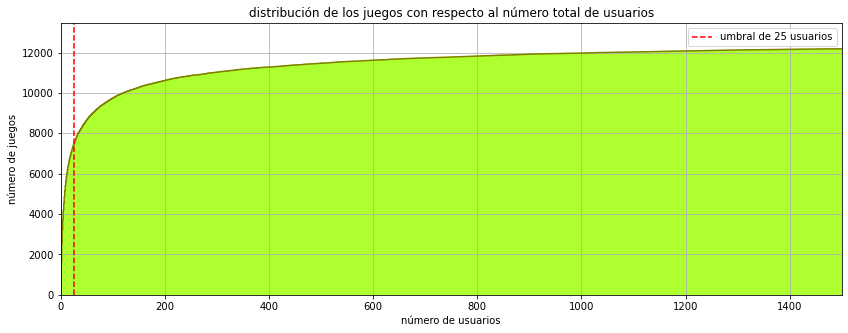

In [31]:
plt.figure(figsize=(14,5))
plt.title('distribución de los juegos con respecto al número total de usuarios')
plt.plot(distribucion_juegos, conteo_juegos, color='olive')
plt.fill_between(distribucion_juegos, conteo_juegos, color='greenyellow')
plt.axvline(x=25, c='r', ls='--', label='umbral de 25 usuarios')
plt.xlabel('número de usuarios')
plt.ylabel('número de juegos')
plt.legend(loc=0)
plt.xlim(0,1500)
plt.ylim(0)
plt.grid()
plt.show()

In [32]:
print('número de juegos con 25 o más usuarios : ',len(distribucion_juegos.values[distribucion_juegos.values >= 25]))
print('número de juegos con menos de 25 usuarios : ',len(distribucion_juegos.values[distribucion_juegos.values < 25]))

número de juegos con 25 o más usuarios :  5442
número de juegos con menos de 25 usuarios :  7380


In [33]:
print('número de reseñas correspondientes a juegos con 25 o más usuarios : ',
      np.sum(distribucion_juegos.values[distribucion_juegos.values >= 25]))
print('número de reseñas correspondientes a juegos con menos de 25 usuarios :',
      np.sum(distribucion_juegos.values[distribucion_juegos.values < 25]))

número de reseñas correspondientes a juegos con 25 o más usuarios :  4740135
número de reseñas correspondientes a juegos con menos de 25 usuarios : 49648


Si bien podemos ver que casi el 60% de los juegos están por debajo del umbral, estos juegos representan apenas el 1% del número total de reseñas, debido a que los juegos más populares tienen decenas o incluso cientos de miles de usuarios. Es por ello que definimos el umbral del número de usuarios por juego en 25.

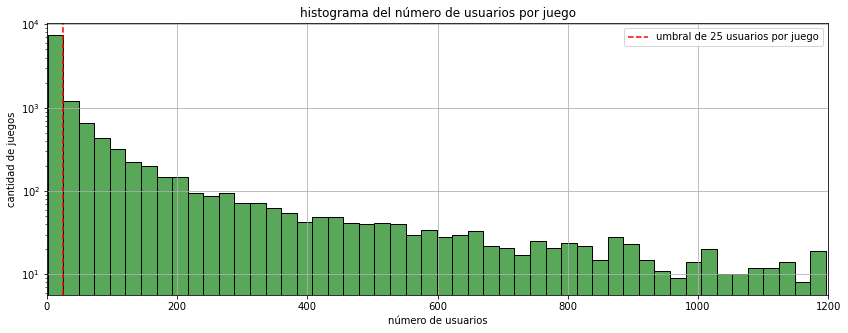

In [34]:
plt.figure(figsize = (14,5))
max_user = 1200
plt.title("histograma del número de usuarios por juego")
sns.histplot(data = distribucion_juegos[distribucion_juegos < max_user], bins = 50, color='forestgreen')
plt.axvline(x=25, c='r', ls='--', label='umbral de 25 usuarios por juego')
plt.xlabel("número de usuarios")
plt.ylabel("cantidad de juegos")
plt.yscale('log')
plt.legend(loc=0)
plt.xlim(0,max_user)
plt.grid()
plt.show()

¿Cuáles son los juegos más jugados, y los menos jugados?

In [35]:
print('Los 20 juegos con más jugadores son los siguientes:\n')
print(list(distribucion_juegos.sort_values(ascending = False).index.map(dict(zip(data_games.id,data_games.title))))[:20])

Los 20 juegos con más jugadores son los siguientes:

['Team Fortress 2', 'Rust', 'Borderlands 2', 'Fallout 4', 'Robocraft', 'Grand Theft Auto V', 'Undertale', 'Warframe', 'DayZ', 'Portal 2', "Garry's Mod", 'Life is Strange - Episode 1', 'Starbound', 'Heroes &amp; Generals', 'Arma 3', 'ARK: Survival Evolved', 'H1Z1', "Sid Meier's Civilization® V", 'Mount &amp; Blade: Warband', 'Paladins®']


In [36]:
print('Los 20 juegos con menos jugadores son los siguientes:\n')
print(list(distribucion_juegos.sort_values(ascending = False).index.map(dict(zip(data_games.id,data_games.title))))[-20:])

Los 20 juegos con menos jugadores son los siguientes:

['Burgle Bros.', 'Ohmicide', 'The Ables: Freepoint High', 'The Grimsworth Reports: Woodfall', 'Nakawak', 'Hearts of Chaos', 'Demesne', 'Kolbeinn', 'Drift Zone', 'The Secret of Pineview Forest', 'MotorSport Revolution', 'Easy French™ Platinum', 'LOGistICAL: USA - Florida', 'Military Life: Tank Simulator', 'Quadrant M4', 'Shiny', 'Nightmare Adventures: The Turning Thorn', 'Ragna Maya', 'Captain Lycop : Invasion of the Heters', 'My Coloring Book: Transport']


Para obtener un dataset más homogéneo eliminaremos los juegos menos populares y presentativos, para ello utilizaremos el umbral presentado arriba de 25 usuarios por juego.

In [37]:
lista_juegos_populares = list(distribucion_juegos.index[distribucion_juegos.values >= 25])
data_reviews = data_reviews[data_reviews.product_id.isin(lista_juegos_populares)]

In [38]:
data_reviews = data_reviews.reset_index(drop = True)
print('El Dataset Reviews tiene dimensiones: ',data_reviews.shape)

El Dataset Reviews tiene dimensiones:  (4740135, 4)


#### Distribución de la variable 'username'

In [39]:
print('el número de usuarios existentes es : ', len(np.unique(data_reviews.username)))

el número de usuarios existentes es :  2113932


In [40]:
distribucion_usuarios = data_reviews.username.value_counts()
print('número de juegos por usuario\n')
print(distribucion_usuarios)

número de juegos por usuario

Sarkoth               667
Alex                  589
Chris                 539
Nick                  528
Tom                   509
                     ... 
⎝૦ઁᗝ૦ઁ⎠ WonderPinX      1
BasS-Junkie-XL          1
Fire Walk with Me       1
vr                      1
madarennep              1
Name: username, Length: 2113932, dtype: int64


Veamos la distribución de los usuarios con respecto al total de juegos y a las reseñas que estos juegos representan. Utilizando esta distribución vamos  a determinar el valor adecuado para el umbral del número de juegos por usuario que será utilizado posteriormente para eliminar los usuarios con muy poco historial, hecho que dificulta encontrar recomendaciones para estos.

In [41]:
distribucion_usuarios = distribucion_usuarios.sort_values(ascending = True)
conteo_usuarios = np.arange(1,len(distribucion_usuarios)+1)

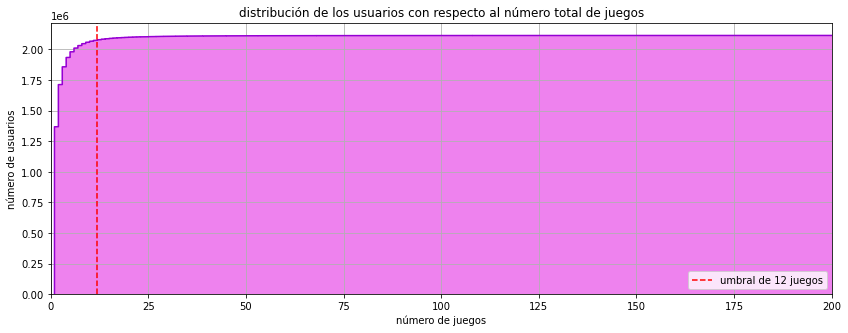

In [42]:
plt.figure(figsize=(14,5))
plt.title('distribución de los usuarios con respecto al número total de juegos')
plt.plot(distribucion_usuarios, conteo_usuarios, color='darkviolet')
plt.fill_between(distribucion_usuarios, conteo_usuarios, color='violet')
plt.axvline(x=12, c='r', ls='--', label='umbral de 12 juegos')
plt.xlabel('número de juegos')
plt.ylabel('número de usuarios')
plt.legend(loc=0)
plt.xlim(0,200)
plt.ylim(0)
plt.grid()
plt.show()

In [43]:
print('número de usuarios con 12 o más juegos : ', len(distribucion_usuarios.values[distribucion_usuarios.values >= 12]))
print('número de usuarios con menos de 12 juegos : ', len(distribucion_usuarios.values[distribucion_usuarios.values < 12]))

número de usuarios con 12 o más juegos :  40748
número de usuarios con menos de 12 juegos :  2073184


In [44]:
print('número de reseñas correspondientes a usuarios con 12 o más juegos : ',
      np.sum(distribucion_usuarios.values[distribucion_usuarios.values >= 12]))
print('número de reseñas correspondientes a usuarios con menos de 12 juegos :',
      np.sum(distribucion_usuarios.values[distribucion_usuarios.values < 12]))

número de reseñas correspondientes a usuarios con 12 o más juegos :  997597
número de reseñas correspondientes a usuarios con menos de 12 juegos : 3742538


Aunque solo el 2% de los usuarios cumple con el umbral propuesto para el número de juegos por usuario, vemos que estos usuarios corresponden al 32% de las reseñas, por lo tanto genera un dataset mucho más homogéneo y puede mejorar los resultados del modelo generado en el proyecto anterior. Es por ello que se define el umbral del número de juegos por usuario en 12.

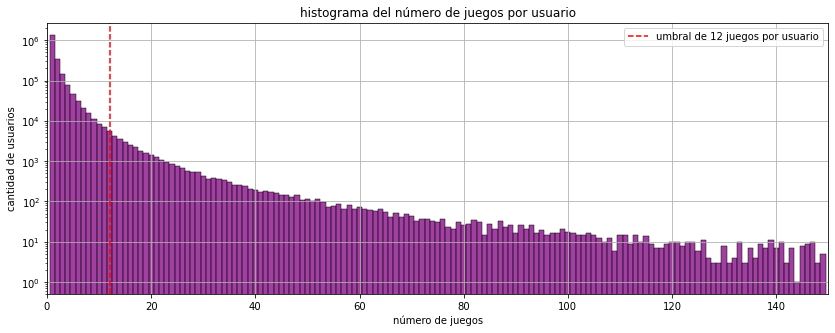

In [45]:
plt.figure(figsize = (14,5))
max_games = 150
plt.title("histograma del número de juegos por usuario")
sns.histplot(data = distribucion_usuarios[distribucion_usuarios < max_games], bins=np.arange(0.5,max_games+0.5), color='purple')
plt.axvline(x=12, c='r', ls='--', label='umbral de 12 juegos por usuario')
plt.xlabel("número de juegos")
plt.ylabel("cantidad de usuarios")
plt.yscale('log')
plt.legend(loc=0)
plt.xlim(0,max_games)
plt.grid()
plt.show()

¿Cuales son los jugadores con mas juegos, y los que tienen menos?

In [46]:
print('Los 20 usuarios con más juegos son los siguientes:\n')
print(list(distribucion_usuarios.sort_values(ascending = False).index[:20]))

Los 20 usuarios con más juegos son los siguientes:

['Sarkoth', 'Alex', 'Chris', 'Nick', 'Tom', 'Saint Aaron', 'Dan', 'Matt', '123', 'Shadow', 'Mike', 'Jack', 'Bob', 'Red', 'Sam', 'John', 'Zero', 'Wolf', 'Blue', 'James']


In [47]:
print('Los 20 usuarios con menos juegos son los siguientes:\n')
print(list(distribucion_usuarios.sort_values(ascending = False).index[-20:]))

Los 20 usuarios con menos juegos son los siguientes:

['ScreCnoKORN', 'Whispstar', 'thomas.brinkmann', 'Spacemustard', 'Buckerton', 'Moonblazer', 'shodenshow', 'Yajo89', 'Sir Bulle III', 'Speiso', 'Doktor Obvious', 'ServError', 'D1MeH', 'Charlard', 'OP DRIFTER', 'DEVIOUSTHEG', '[FestiveNapkins]Black', 'NixorGinix', 'Paint.exe', 'LOVECREAMPIE/YOUPORN.COM']


Utilizaremos el umbral de juegos por usuario para eliminar del dataset los usuarios con poco historial. 

In [48]:
lista_usuarios = list(distribucion_usuarios.index[distribucion_usuarios.values >= 12])
data_reviews = data_reviews[data_reviews.username.isin(lista_usuarios)]

In [49]:
data_reviews = data_reviews.reset_index(drop = True)
print('El Dataset Reviews tiene dimensiones: ',data_reviews.shape)

El Dataset Reviews tiene dimensiones:  (997597, 4)


Eliminemos del dataset games los juegos que no cuentan con entradas en el dataset reviews, luego del preprocesamiento realizado en el dataset reviews

In [50]:
juegos_existentes = list(np.unique(data_reviews.product_id))
data_games = data_games[data_games.id.isin(juegos_existentes)]

In [51]:
data_games = data_games.reset_index(drop = True)
print('El Dataset Games tiene dimensiones: ',data_games.shape)

El Dataset Games tiene dimensiones:  (5442, 7)


#### Análisis de la descripción 'text'

In [93]:
import nltk
import re
from nltk.util import ngrams

stopwords = nltk.corpus.stopwords.words('english')

Ahora que hemos realizado preprocesamiento al dataset para obtener un conjunto de referencias que indican una preferencia positiva (gusto del usuario por el juego), aplicaremos procesamiento de lenguaje natural (NLP) a la característica texto para identificar las palabras mas comunes en estas descripciones y corroborar que se traten de comentarios positivos.

Filtraremos todas las stopwords (palabras comunes del lenguaje), las palabras con menos de 3 caracteres y algunas palabras muy comunes del texto (y sus variantes) que no nos informan mucho por si solas, como **game, play, time, level, also, still** entre otras.

In [53]:
%%time

todos_textos = []
for texto in data_reviews.text:
    texto = re.sub("[^a-zA-Z]"," ",str(texto))
    texto = texto.lower()
    texto = nltk.tokenize.word_tokenize(texto)
    texto = [word for word in texto if word not in stopwords]      
    texto = [word for word in texto if len(word)>2]
    todos_textos.append(texto)

todas_palabras = [word for texto in todos_textos for word in texto]

Wall time: 21min 21s


In [54]:
filtrar = ['game','games','gameplay','play','played','playing','time','also','people','though',
           'even','still','level','combat','characters']

todas_palabras_filtradas = [word for word in todas_palabras if word not in filtrar]

In [55]:
frecuencia_palabras = nltk.FreqDist(todas_palabras_filtradas)
dataframe_words = pd.DataFrame(list(frecuencia_palabras.items()), columns = ["Word","Frequency"])
dataframe_words.sort_values('Frequency', ascending=False, inplace = True)
dataframe_words.reset_index(drop = True, inplace=True)

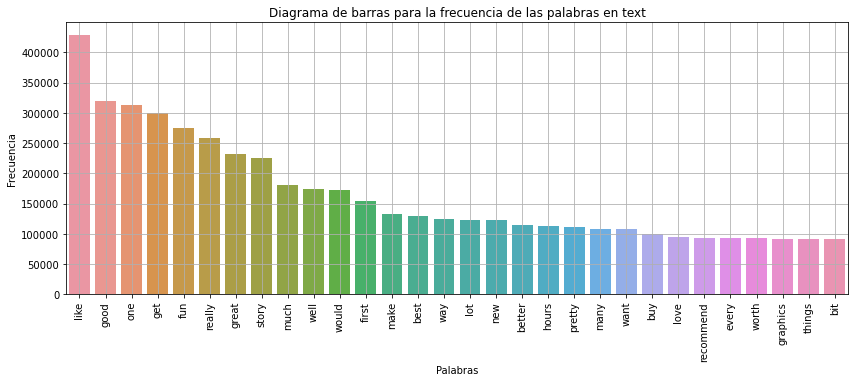

In [56]:
num_words = 30
plt.figure(figsize = (14,5))
plt.title('Diagrama de barras para la frecuencia de las palabras en text')
sns.barplot(x = dataframe_words.iloc[:num_words].Word, y = dataframe_words.iloc[:num_words].Frequency)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Podemos observar entre las palabras mas comunes **like, good, one, fun, great, best, better, pretty, love, worth** entre otras, que tienen un sentido positivo, y ninguna de las palabras con sentido negativo como serían **bad, awfull, crash, terrible, worst**.

Ahora realizaremos un análisis de bigramas y trigramas. en estos tambien filtraremos las stopwords y palabras con menos de 3 caracteres.

In [57]:
%%time

ngramas_2 = []
ngramas_3 = []

for texto in data_reviews.text:
    texto = re.sub("[^a-zA-Z]"," ",str(texto))
    texto = texto.lower()
    texto = nltk.tokenize.word_tokenize(texto)
    texto = [word for word in texto if word not in stopwords]
    texto = [word for word in texto if len(word)>2]
    texto = (' ').join(texto)
    tokens = [token for token in texto.split(" ") if token != ""]
    tokens_2 = list(ngrams(tokens, 2))
    tokens_3 = list(ngrams(tokens, 3))
    ngramas_2.append(tokens_2)
    ngramas_3.append(tokens_3)

todos_ngramas_2 = [ngram for ngram_texto in ngramas_2 for ngram in ngram_texto]
todos_ngramas_3 = [ngram for ngram_texto in ngramas_3 for ngram in ngram_texto]

Wall time: 25min 17s


In [58]:
frecuencia_ngramas_2 = nltk.FreqDist(todos_ngramas_2)
dataframe_ngramas_2 = pd.DataFrame(list(frecuencia_ngramas_2.items()), columns = ["Word","Frequency"])
dataframe_ngramas_2.sort_values('Frequency', ascending=False, inplace = True)
dataframe_ngramas_2.reset_index(drop = True, inplace=True)

In [59]:
frecuencia_ngramas_3 = nltk.FreqDist(todos_ngramas_3)
dataframe_ngramas_3 = pd.DataFrame(list(frecuencia_ngramas_3.items()), columns = ["Word","Frequency"])
dataframe_ngramas_3.sort_values('Frequency', ascending=False, inplace = True)
dataframe_ngramas_3.reset_index(drop = True, inplace=True)

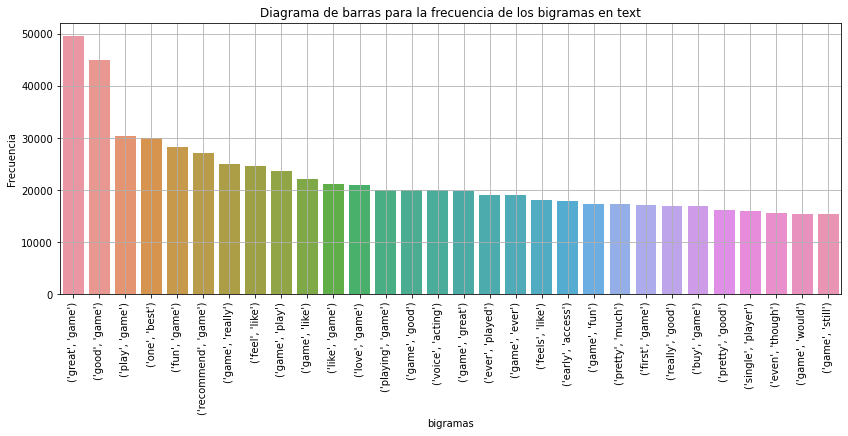

In [60]:
num_ngrams = 30
plt.figure(figsize = (14,5))
plt.title('Diagrama de barras para la frecuencia de los bigramas en text')
sns.barplot(x = dataframe_ngramas_2.iloc[:num_ngrams].Word, y = dataframe_ngramas_2.iloc[:num_ngrams].Frequency)
plt.xlabel('bigramas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.grid()
plt.show()

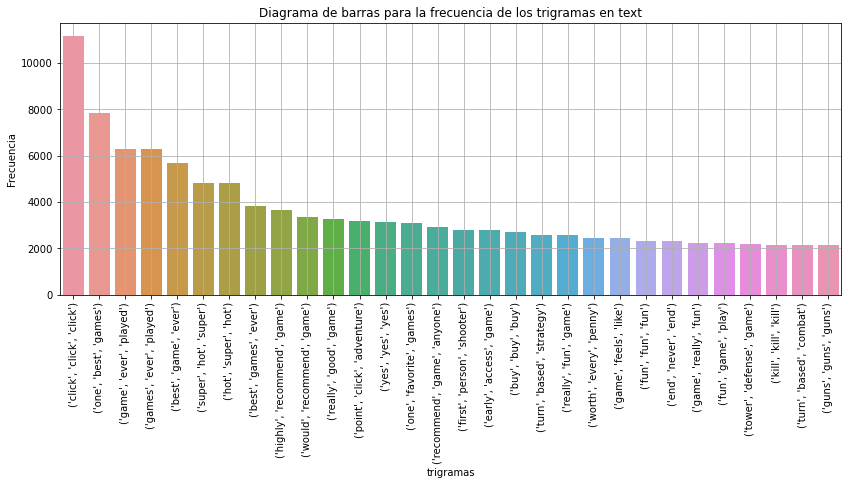

In [61]:
num_ngrams = 30
plt.figure(figsize = (14,5))
plt.title('Diagrama de barras para la frecuencia de los trigramas en text')
sns.barplot(x = dataframe_ngramas_3.iloc[:num_ngrams].Word, y = dataframe_ngramas_3.iloc[:num_ngrams].Frequency)
plt.xlabel('trigramas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Vemos que entre los bigramas mas comunes están **(great, game),(good, game),(one, best),(fun, game),(recommend, game),(love, game),(like, game),(game, great),(really, good),(pretty, good)** entre otros, y entre los trigramas mas comunes están **(one, best, games),(best, game, ever),(highly, recommend, game),(would, recommend, game),(really, good, game),(one, favorite, games),(yes, yes, yes),(fun, fun, fun),(game, really, fun)** entre otros. 

Estos tienen un sentido positivo mucho mas claro que en análisis anterior, ya que ahora no contamos solo con palabras positivas si no con expresiones que indican claramente un sentimiento positivo. En ninguno de los bigramas o trigramas principales encontramos alguna expresión que denote un sentido negativo.

Por ello se puede declarar que los comentarios de los usuarios hacia los juegos son positivos, como esperamos.

#### Dataset Games

#### Distribución de la variable 'developer'

In [52]:
print('número de desarrolladores existentes : ', len(list(data_games.developer.value_counts().index)))

número de desarrolladores existentes :  3622


In [53]:
distribucion_desarrolladores = data_games.developer.value_counts()
print('número de juegos por desarrollador\n')
print(distribucion_desarrolladores)

número de juegos por desarrollador

Valve                                    24
Square Enix                              20
Choice of Games                          19
KOEI TECMO GAMES CO., LTD.               18
Telltale Games                           17
                                         ..
MachineGames                              1
Red Winter Software                       1
tobyfox                                   1
Ironclad Games,Stardock Entertainment     1
Mindware Studios                          1
Name: developer, Length: 3622, dtype: int64


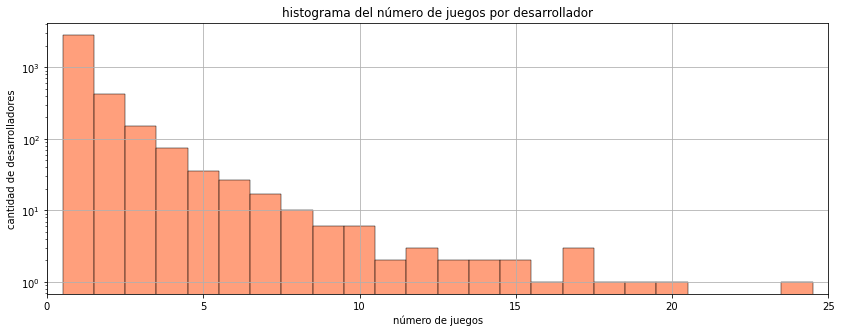

In [54]:
max_user = 25
plt.figure(figsize = (14,5))
plt.title("histograma del número de juegos por desarrollador")
sns.histplot(data = distribucion_desarrolladores[distribucion_desarrolladores < max_user], bins=np.arange(0.5,max_games+0.5), 
             color='coral')
plt.xlabel("número de juegos")
plt.ylabel("cantidad de desarrolladores")
plt.yscale('log')
plt.xlim(0,max_user)
plt.grid()
plt.show()

#### Distribución de la variable 'price'

In [55]:
price = []
for element in data_games.price:
    if type(element) == str:
        element = element.lower()
    price.append(element)

data_games['price'] = price

In [56]:
print('Número de juegos free to Play: ', len(data_games[data_games.price == 'free to play']))

Número de juegos free to Play:  427


In [57]:
print('Número de juegos sin información del precio: ', data_games.price.isna().sum())

Número de juegos sin información del precio:  59


In [58]:
data_games_with_prices = data_games[pd.to_numeric(data_games.price, errors='coerce').notnull()]

Algunos estadisticos de la distribución de los precios

In [59]:
print('promedio : %0.2f' % (data_games_with_prices.price.mean()))
print('std :      %0.2f' % (data_games_with_prices.price.std()))
print('mínimo :   %0.2f' % (data_games_with_prices.price.min()))
print('Q1 :       %0.2f' % (data_games_with_prices.price.quantile(0.25)))
print('mediana :  %0.2f' % (data_games_with_prices.price.quantile(0.5)))
print('Q3 :       %0.2f' % (data_games_with_prices.price.quantile(0.75)))
print('máximo :   %0.2f' % (data_games_with_prices.price.max()))

promedio : 14.39
std :      16.93
mínimo :   0.49
Q1 :       6.99
mediana :  9.99
Q3 :       19.99
máximo :   771.71


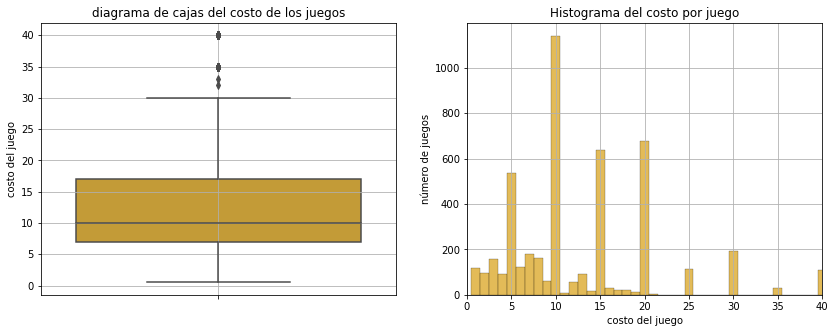

In [60]:
plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
max_price = 40
sns.boxplot(y = data_games_with_prices.price[data_games_with_prices.price<max_price], color='goldenrod')
plt.title("diagrama de cajas del costo de los juegos")
plt.ylabel("costo del juego")
plt.grid()
plt.subplot(1,2,2)
sns.histplot(data = data_games_with_prices.price[data_games_with_prices.price<max_price], 
             bins = np.arange(0.5,max_games+0.5), color='goldenrod')
plt.title("Histograma del costo por juego")
plt.xlabel("costo del juego")
plt.ylabel("número de juegos")
plt.xlim(0,max_price)
plt.grid()
plt.show()

¿Cuales son los juegos mas caros, y los mas baratos?

In [61]:
print('Los 20 juegos mas costosos son los siguientes:\n')
print(list(data_games_with_prices.sort_values(by=['price','title'], ascending=False).title.values)[:20])

Los 20 juegos mas costosos son los siguientes:

['X-Plane 10 Global - 64 Bit', 'MODO indie 10', 'Pinball FX3', 'VEGAS Pro 14 Edit Steam Edition', 'ACE - Arena: Cyber Evolution', 'RaceRoom Racing Experience', 'HIS (Heroes In the Sky)', 'Silo 2', 'GameMaker Studio 2 Desktop', 'Clickteam Fusion 2.5', '3D-Coat V4.8', 'HEX: Shards of Fate', 'RPG Maker MV', "Gary Grigsby's War in the East", 'Command: Modern Air / Naval Operations WOTY', 'AppGameKit: Easy Game Development', 'Sleeping Dogs', 'SMILE GAME BUILDER', 'RPG Maker VX Ace', 'SEGA Mega Drive and Genesis Classics']


In [62]:
print('Los 20 juegos mas baratos son los siguientes:\n')
print(list(data_games_with_prices.sort_values(by=['price','title'], ascending=True).title.values)[:20])

Los 20 juegos mas baratos son los siguientes:

['Fate Tectonics', 'Out There Somewhere', 'Super Star Path', 'PARTICLE MACE', '#monstercakes', '1 Moment Of Time: Silentville', '3DRPG', "A Detective's Novel", 'A grande bagunça espacial - The big space mess', 'Alpha Runner', 'Ampersand', 'Bacteria', "Bad Rats: the Rats' Revenge", 'Bit Blaster XL', 'Blacklight: Tango Down', 'Blitz Breaker', 'Blood and Bacon', 'CRACKHEAD', 'Catch a Falling Star', 'Cats are Liquid']


#### Distribución de la variable 'genres'

In [63]:
generos = []
for lista in data_games.genres:
    if type(lista) == list:
        generos.append(lista)

In [64]:
generos = [item 
           for sublist in generos
           for item in sublist]

In [65]:
index_generos = list(np.unique(generos))
values_generos = [generos.count(item) for item in index_generos]

distribucion_generos = pd.Series(values_generos, index = index_generos) 
distribucion_generos = distribucion_generos.sort_values(ascending=False)

In [66]:
print('distribución de los generos por número de juegos:\n')
print(distribucion_generos)

distribución de los generos por número de juegos:

Indie                        3077
Action                       2424
Adventure                    1900
Strategy                     1456
RPG                          1285
Casual                       1021
Simulation                    993
Free to Play                  510
Early Access                  388
Massively Multiplayer         278
Sports                        218
Racing                        201
Utilities                      45
Design &amp; Illustration      32
Animation &amp; Modeling       26
Web Publishing                 18
Video Production               17
Education                      12
Software Training              12
Audio Production               10
Photo Editing                   4
dtype: int64


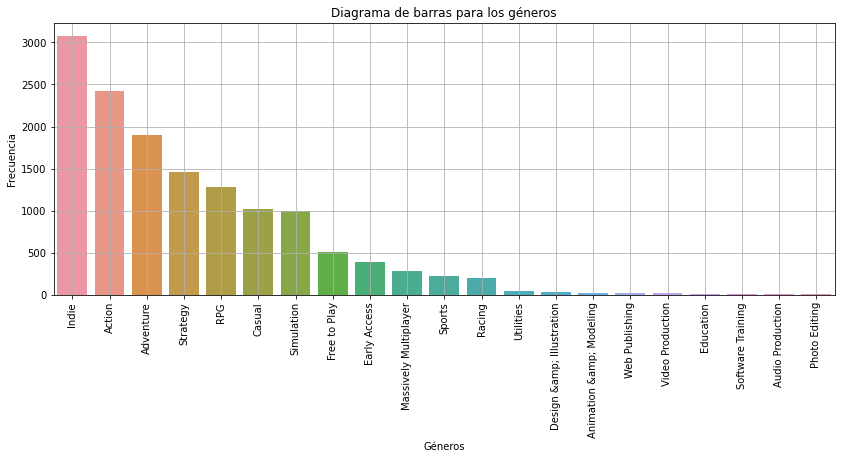

In [67]:
plt.figure(figsize = (14,5))
plt.title('Diagrama de barras para los géneros')
sns.barplot(x = distribucion_generos.index, y = distribucion_generos.values)
plt.xlabel('Géneros')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.grid()
plt.show()

#### Distribución de la variable 'tags'

In [68]:
etiquetas = []
for lista in data_games.tags:
    if type(lista) == list:
        etiquetas.append(lista)

In [69]:
etiquetas = [item 
            for sublist in etiquetas
            for item in sublist]

In [70]:
index_etiquetas = list(np.unique(etiquetas))
values_etiquetas = [etiquetas.count(item) for item in index_etiquetas]

distribucion_etiquetas = pd.Series(values_etiquetas, index = index_etiquetas) 
distribucion_etiquetas = distribucion_etiquetas.sort_values(ascending=False)

In [71]:
print('distribución de las etiquetas por número de juegos:\n')
print(distribucion_etiquetas)

distribución de las etiquetas por número de juegos:

Indie            3332
Singleplayer     2932
Action           2892
Adventure        2649
Strategy         1766
                 ... 
Steam Machine       2
Hardware            2
Faith               1
Underground         1
Foreign             1
Length: 335, dtype: int64


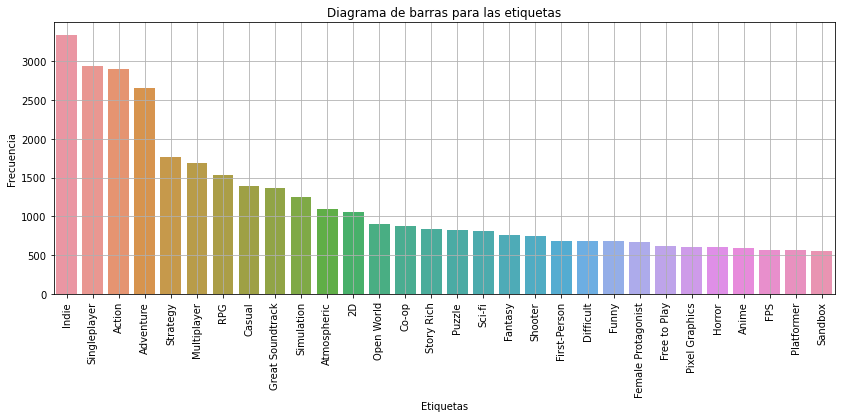

In [72]:
num_etiquetas = 30
plt.figure(figsize = (14,5))
plt.title('Diagrama de barras para las etiquetas')
sns.barplot(x = distribucion_etiquetas[:num_etiquetas].index, y = distribucion_etiquetas[:num_etiquetas].values)
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.grid()
plt.show()

#### Distribución de la variable 'specs'

In [73]:
especificaciones = []
for lista in data_games.specs:
    if type(lista) == list:
        especificaciones.append(lista)

In [74]:
especificaciones = [item 
                   for sublist in especificaciones
                   for item in sublist]

In [75]:
index_especificaciones = list(np.unique(especificaciones))
values_especificaciones = [especificaciones.count(item) for item in index_especificaciones]

distribucion_especificaciones = pd.Series(values_especificaciones, index = index_especificaciones) 
distribucion_especificaciones = distribucion_especificaciones.sort_values(ascending=False)

In [76]:
print('distribución de las especificaciones por número de juegos:\n')
print(distribucion_especificaciones)

distribución de las especificaciones por número de juegos:

Single-player                 4979
Steam Achievements            3521
Steam Trading Cards           2969
Steam Cloud                   2296
Multi-player                  1625
Full controller support       1458
Partial Controller Support    1009
Steam Leaderboards             987
Co-op                          720
Stats                          534
Online Multi-Player            512
Shared/Split Screen            494
Cross-Platform Multiplayer     439
Steam Workshop                 406
Includes level editor          390
In-App Purchases               271
Captions available             266
Online Co-op                   252
MMO                            235
Local Multi-Player             189
Local Co-op                    141
Valve Anti-Cheat enabled       101
Commentary available            56
Includes Source SDK             31
Steam Turn Notifications        23
Mods                            10
Mods (require HL2)            

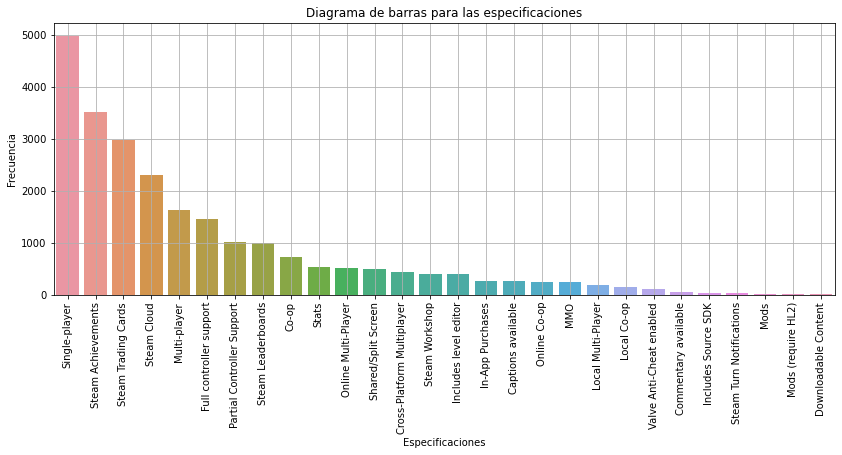

In [77]:
plt.figure(figsize = (14,5))
plt.title('Diagrama de barras para las especificaciones')
sns.barplot(x = distribucion_especificaciones.index, y = distribucion_especificaciones.values)
plt.xlabel('Especificaciones')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.grid()
plt.show()

#### generación de las preferencias y los indices de usuario y juego continuos

Debido a que previamente realizamos un preprocesamiento para obtener solo las reseñas positivas (que indican gusto de un usuario por un juego), la caracteristica rating tomará el valor de 1 para todas las reseñas existente.

In [78]:
data_reviews['ratings'] = 1

Ahora vamos a generar una identificación numérica continua para los usuarios

In [79]:
usuarios = list(np.unique(data_reviews.username))
usuarios_encooded = np.arange(0,len(usuarios))

In [80]:
data_reviews['user_id'] = data_reviews.username.map(dict(zip(usuarios,usuarios_encooded)))

Finalmente generaremos una identificación numérica continua para los juegos, que debemos reemplazar en ambos datasets

In [81]:
juegos = list(np.unique(data_reviews.product_id))
juegos_encooded = np.arange(0,len(juegos))

In [82]:
data_reviews['game_id'] = data_reviews.product_id.map(dict(zip(juegos,juegos_encooded)))

In [83]:
data_games['game_id'] = data_games.id.map(dict(zip(juegos,juegos_encooded)))

#### Contrucción de una matriz de contenidos para los juegos

A partir del dataset games contruiremos una matriz que albergue los contenidos como variables one hot encoding. Esta será utilizada para el desarrollo de un modelo adicional basado en contenidos

In [94]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

pd.options.mode.chained_assignment = None 

In [95]:
data_games_prueba = data_games.copy()

Lo primero que haremos es unir todas las caracteristicas que contiene la columna géneros, etiquetas y specificaciones, y codificar cada una en una variable dummy, que toma los valores de 1 o 0 para juegos si este juego posee dicha caracteristica o no

In [96]:
data_games_prueba['allwords'] = data_games_prueba.genres + data_games_prueba.tags + data_games_prueba.specs
data_games_prueba.fillna(value='', inplace=True)

In [97]:
mlb = MultiLabelBinarizer()
data_encooded1 = mlb.fit_transform(data_games_prueba['allwords'])
data_encooded1 = pd.DataFrame(data_encooded1,columns=mlb.classes_).reset_index(drop = True)
data_encooded1 = data_encooded1.astype(int)

Ahora tomaremos la columna desarrolladores y generaremos variables dummy con cada empresa desarroladora. Utilizaremos solo aquellos desarrolladores que tienen 5 o mas juegos para no llenar el dataset de una gran mayoria de pequeños desarrolladores.

In [98]:
desarrolladores = data_games_prueba.developer.value_counts()
desarrolladores = list(desarrolladores.index[desarrolladores.values>=5])
data_games_prueba.developer.loc[~data_games_prueba.developer.isin(desarrolladores)] = ''

In [99]:
ohe = OneHotEncoder(sparse=False) 
data_encooded2 = ohe.fit_transform(data_games_prueba['developer'].values.reshape(-1,1))
data_encooded2 = pd.DataFrame(data_encooded2,columns=ohe.categories_).reset_index(drop = True)
data_encooded2.drop([''], axis=1, inplace=True)
data_encooded2 = data_encooded2.astype(int)

Finalmente tomaremos la columna titulos y realizaremos algo de preprocesamiento de lenguaje natural (NLP) para eliminar simbolos y stopwords de estos. con los titulos obtenidos realizamos una vectorización (representación binaria de cada palabra como  en el conjunto total de títulos como una variable dummy). limitaremos la vectorización a las 600 palabras mas comunes para no hacer un dataset innecesariamente enorme.

In [100]:
titulos = list(data_games_prueba.title.values)

filtrar = ['edition','game','online','amp','iii','rpg','remastered']

In [101]:
todos_titulos = []

for titulo in titulos:
    titulo = re.sub("[^a-zA-Z]"," ",str(titulo))
    titulo = titulo.lower()
    titulo = nltk.tokenize.word_tokenize(titulo)
    titulo = [word for word in titulo if word not in stopwords]      
    titulo = [word for word in titulo if word not in filtrar]
    titulo = [word for word in titulo if len(word)>2]
    titulo = (' ').join(titulo)
    todos_titulos.append(titulo)

In [102]:
covec = CountVectorizer(max_features=600)
data_encooded3 = covec.fit_transform(todos_titulos)
data_encooded3 = data_encooded3.toarray()
data_encooded3 = data_encooded3.astype(int)
data_encooded3 = pd.DataFrame(data_encooded3,columns=covec.get_feature_names()).reset_index(drop = True)

finalmente concatenamos cada uno de los 3 datasets que acabamos de crear, junto con la codificación de cada juego, que utilizaremos como indice del dataset final

In [103]:
data_games_content = pd.concat([data_games_prueba[['game_id']], data_encooded1, data_encooded2, data_encooded3], axis=1)
data_games_content.set_index('game_id', inplace=True)
data_games_content.sort_index(inplace = True)

#### Eliminamos la información innecesaria para el desarrollo del sistema de recomendación

In [104]:
data_reviews.drop(['hours','product_id','text'],axis=1, inplace=True)

In [105]:
data_games.drop(['genres','tags','specs','price','id','developer'],axis=1, inplace=True)

#### Vamos a guardar los datasets modificados como archivos .csv

In [106]:
data_reviews.to_csv('data_reviews.csv', index= False)
data_games.to_csv('data_games.csv', index= False)
data_games_content.to_csv('data_games_content.csv', index= False)

In [107]:
data_reviews = pd.read_csv('data_reviews.csv')
data_games = pd.read_csv('data_games.csv')
data_games_content = pd.read_csv('data_games_content.csv')

### Formulación y desarrollo del sistema de recomendación

Para la implementación de los modelos utilizaremos la librería [Implicit](https://implicit.readthedocs.io/en/latest/), que se especializa en el manejo de Datasets de feedback implicito.

Para la optimización de los modelos utilizaremos la libreria [scikit-optimize](https://scikit-optimize.github.io/stable/), que nos permite desarrollar una optimización bayesiana, lo que reduce considerablemente el tiempo de optimización de los hiperparámetros, comparado con la optimización con grilla desarrollada en el proyecto 3.

De esta manera, realizamos todas las importaciones de librerias pertinentes.

In [3]:
from scipy import sparse

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender
from implicit.evaluation import train_test_split, ranking_metrics_at_k
from sklearn.metrics.pairwise import cosine_similarity

from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from skopt.callbacks import DeltaYStopper, DeadlineStopper
from skopt.plots import plot_convergence

import os
os.environ['MKL_NUM_THREADS'] = '1'

import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

#### Presentación de los modelos y métrica utilizados 

Los sistemas de recomendación recolectan la información sobre las preferencia de los usuarios y a partir de esta les presentan nuevos items que sean de su interes, sin preguntarles explicitamente por lo que prefieren. Permiten ampliar el catálogo de productos a ofrecer ya que evita el fenómeno conocido como [long tail](https://medium.com/@kyasar.mail/recommender-systems-what-long-tail-tells-91680f10a5b2) y ademas le ahorra mucho tiempo al usuario que pasaría buscando los items de su preferencia, lo que mejora su experiencia como consumidor. Los sistemas de recomendación se dividen principalmente en dos tipos, basado en contenidos y de filtro colaborativo

**sistemas basados en contenido**: usan las caracteristicas de los items por los cuales un usuario tiene preferencia para recomendar otros items similares a estos al usuario. Por ejemplo, si el usuario siente preferencia por los juegos de deportes desarrollados por la empresa EA, los items recomendados tendrán estas mismas caracteristicas. Estos sistemas utilizan medidas de similitud entre las caracteristicas de los items para determinar cuales son mas similares entre si y partir de estas desarrollad un algoritmo de K vecinos mas cercanos (KNN)

**sistemas de filtro colaborativo**: busca similitudes entre usuarios e items para recomendar a un usuario especifico los items por los cuales los usuarios mas similares a este tienen preferencia. Por ejemplo si el usuario tiene preferencia por los juegos de deportes y otros jugadores tienen preferencia por juegos de deporte de manera similar al usuario y ademas tiene preferencia por juegos de ciencia ficción, al usuario pueden ser recomendados estos juegos de ciencia ficción esperando que al igual que otros usuarios similares tenga preferencia por estos. Los sistemas de recomendación del tipo de filtro colaborativo se dividen en dos grupos:

1. Basados en memoria: Estos utilizan el conjunto completo de los datos y desarrollan medidas de similitud entre estos para encontrar similitudes entre conjuntos de items y de usuarios. Los algoritmos de K vecinos mas cercanos (KNN) son un ejemplo.
2. Basados en modelo: Estos desarrollan diversos modelos de aprendizaje automatico, como pueden ser factorización de matrices (MF) , Descomposición de valores singulares (SVD) o redes neuronales, y a partir de ellos determinan las relaciones entre items y usuarios.

En estos proyecto desarrollaremos un algoritmo basado en contenidos (utilizando las caracteristicas de los juegos proveidas en el dataset games), dos algoritmos de filtro colaborativo basados en memoria (uno utilizando medida de similitud coseno y otro BM25) y un algoritmo de filtro colaborativo basado en modelo que utiliza factorización matricial. Ademas compararemos el rendimiento de estos enfoques con un caso de referencia, que corresponde a la recomendación segun el Top de popularidad de los items. A continuación explicaremos mas en detalle los algoritmos utilizados

#### Algoritmo de K vecinos mas cercanos (KNN)

El algoritmo de KNN considera los K elementos (siendo K un hiperparámetro) mas cercanos al elemento del cual se desea predecir su interacción o preferencia y califica dicha interacción segun la observación de las interacciones conocidas cercanas. Para el desarrollo de este enfoque debe definirse una medida de la cercania  o similitud entre las observaciones, algunas de las mas conocidas son similitud coseno, jacard. En el campo de la recuperación de información algunas medidas de similitud son [BM25](https://sigir-ecom.github.io/ecom18DCPapers/ecom18DC_paper_8.pdf) y TFIDF.

Para cada usuario $u$ dentro del conjunto total de usuarios $U$ y cada par de items $i,j$ dentro del conjunto total de items $I$ la medida de similitud coseno se presenta a continuación

$$ Sim_{i,j} = \displaystyle \frac{\sum_{u\in U_{i,j}} r_{u,i} \cdot r_{u,j}}
{\sqrt{\sum_{u\in U_{i,j}} r_{u,i}^{2}} \cdot \sqrt{\sum_{u\in U_{i,j}} r_{u,j}^{2}}} $$

Donde $r_{ui}$ es la interacción de un usuario $u$ por un item $i$. Esta medida toma valores entre -1 y 1 y mientras mas cercana a 1 indica una mayor preferencia

La medida de similitud BM25, viene originalmente de un algoritmo de calificación para asignar relevancia, desarrollado en el campo del procesamiento de lenguaje natural (NLP), y a partir de de este se presentó posteriormente una medida de similitud basada en una función de puntuación [que se detalla aquí](http://ipl.cs.aueb.gr/stougiannis/bm25.html#:~:text=The%20BM25%20similarity%20function&text=%7C%20d%20%7C%20is%20the%20length%20of,the%20documents%20of%20the%20collection.)

En el sistema de recomendación basado en contenidos desarrollado emplea media de similitud coseno a sobre la matriz de caracteristicas de los items y los sistemas tipo filtro colaborativo basados en memoria utilizan medidas de similitud coseno y BM25 sobre la matriz de utilidad item - usuario.

#### Modelo de mínimos cuadrados alternantes (ALS)

El modelo de mínimos cuadrados alternantes está basado en el algoritmo presentado en el artículo [Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf), este es un modelo de factores latentes, al igual que SVD. Este tipo de modelos tipicamente asocian cada usuario $u$ dentro del conjunto total de usuarios $U$ con un vector factor usuario $x_{u}$ y cada item $i$ dentro del conjunto total de items $I$ con un vector factor item $y_{i}$. 

Debido a que estamos desarrollando un modelo implicito, vamos a introducir un conjunto de variables binarias $p_{ui}$ que indican la preferencia de un usuario $u$ por un item $i$. Los valores de $p_{ui}$ se derivan de la binarización de los valores $r_{ui}$ como se da a continuación

$$p_{ui}=\begin{cases} 1& \ r_{ui} 	\geq 5\\ 0& \ r_{ui} < 5 \end{cases}$$

Donde $r_{ui}$ es la interacción en horas de un usuario $u$ con un item $i$. Para este dataset se propuso un umbral de 5 horas para definir si un jugador tuvo preferencia por un juego. De esta manera la predicción $p_{ui}$ para el usuario $u$ sobre el item $i$ se calcula desarrollando el producto vectorial de la siguiente manera 

$$p_{ui} = x_{u}^{T}y_{i}$$

Ahora definimos la confianza $c_{ui}$ que es una medida de la confianza en la observación $p_{ui}$. Esta surge debido a que la matriz item usuario tiene muchos mas espacios vacios y por ello debemos darle un peso mucho mas alto a las posiciones positivas (unos, que demuestran que el usuario tuvo una preferencia por el juego) para compensar. Esto se logrará escalando la matriz original por algun parámetro alpha, lo que le dará el peso deseado a las posiciones positivas y las negativas (0) permanecerán iguales. De tal manera definimos la confianza $c_{ui}$ para el usuario $u$ en el item $i$ como se ve a continuación

$$c_{ui} = \alpha p_{ui}$$

la mejor manera de determinar este parámetro $\alpha$ es por medio de validación cruzada. Finalmente el término $\lambda$ es la tasa de regularización que evita que el modelo se sobreajuste y penaliza el crecimiento de los vectores factor usuario $x_{u}$ e item $y_{i}$

La función de costo del método es la siguiente

$${min}_{x,y} \sum_{u,i} c_{ui}(p_{ui} - x_{u}^{T}y_{i})^{2} + \lambda \bigg(\sum_{u} \|x_{u}\|^{2} + \sum_{i} \|y_{i}\|^{2}\bigg)$$

La minimización de esta función se desarrolla con el método de gradiente conjugado desarrollado en el artículo [Applications of the Conjugate Gradient Method for Implicit Feedback Collaborative Filtering](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.379.6473&rep=rep1&type=pdf).

#### Elección de la métrica de evaluación

La precisión media promedio a $K$ items $(MAP@K)$ será la métrica utilizada para evaluar el desempeño del modelo. A diferencia de otras métricas que no distinguen la posición de las recomendaciones relevantes, esta métrica si permite darle mas peso a los errores que ocurren mas arriba en la lista de recomendaciones. Ademas es una métrica muy util para los datasets binarios, como es nuestro caso, debido a la función que introduce de relevancia.

Para entender esta métrica debemos definir la precisión, que se presenta a continuación

$$ P = \frac{\text{número de items relevantes en la lista}}{\text{número de items en la lista}}$$

Ademas la relevancia se define como la siguiente función por tramos

$$relevancia = \begin{cases} 1& \ \text{si el item es relevante} \\ 0& \ \text{si el item no es relevante} \end{cases}$$

Con estas dos se define para cada usuario la precisión media a $K$ items como la sumatoria de las precisiones de los elementos relevantes en $K$ sobre el número total de elementos relevantes en $K$

$$ AveP@K = \displaystyle \frac{\sum_{k=1}^{K} P(k) \times relevancia(k)}{\text{número de items relevantes}} $$

Finalmente para obtener un valor para el conjunto completo de usuarios se define la presición media promedio a $K$ items como el promedio de las precisiones medias a $K$ items para cada usuario $u$

$$ MAP@K = \displaystyle \frac{\sum_{u=1}^{U} AveP(u)}{N} $$

Para el cálculo de la métrica utilizaremos un valor de $K$ igual a 20, considerando este un número adecuado de recomendaciones sin hacerse demasiado extenso como para que el usuario pierda interes en la lista o la omita

#### Optimización bayesiana para los hiperparámetros 

Los modelos se evaluaran utilizando la métrica elegida y desarrollando un procedimiento de validación cruzada (efectuando una iteración por cada usuario en el dataset de prueba). Los algoritmos que solo poseen un hiperparámetro pueden ser facilmente optimizados por una busqueda exhaustiva de valores, mientras que para aquellos que poseen varios hipeparámetros se desarrollara un procedimiento de [optimización bayesiana para los hiperparámetros](https://machinelearningmastery.com/what-is-bayesian-optimization/) utilizando procesos gausianos. La idea de este procedimiento es aproximar la función de costo como la superposición de funciones gausianas y apartir de este enfoque evaluar la métrica obtenida con cada iteración para buscar la configuración de hiperparámetros que minimice la función de costo. 

La gran ventaja que tiene este enfoque es el algoritmo aprende de los resultados anteriores y se ajusta hasta cumplir con las condiciones solicitadas de convergencia; a diferencia de la optimización por grilla o por randomizado que requiere un gran número de iteraciones, lo que se ve reflejado en tiempos de ejecución mucho mayores. La implementación de este método de optimización se presenta como una alternativa frente a la principales sugerencias de mejora de los anteriores proyectos en torno a profundizar mas sobre la optimización de hiperparámetros

#### Transformación del dataset

A partir de la información que tenemos debemos construir una matriz de utilidad (item, usuario) que cuenta con la totalidad de interacciones posibles entre items $i$ y usuarios $u$ y que tomará los valores de calificación de un usuario por un juego ($1$ o $0$) y los albergará en una matriz con dimensiones ($I$, $U$). Esta matriz está en formato CSR (compressed sparse row matrix), será utilizada en el entrenamiento de los modelos. 

Una segunda matriz de utilidad (usuario, item) se genera por medio de la transpuesta de la primera matriz. Esta matriz será usada posteriormente en la recomendación de los items.

In [4]:
data = data_reviews[['game_id','user_id','ratings']]

In [5]:
matrix_item_user = sparse.csr_matrix((data['ratings'].astype(float), (data['game_id'], data['user_id'])))
matrix_user_item = matrix_item_user.transpose()

In [6]:
print('La matriz item - usuario tiene dimensiones ', matrix_item_user.shape)

La matriz item - usuario tiene dimensiones  (5442, 40748)


A partir del dataset hacemos una partición en el conjunto de entrenamiento (train) y el conjunto de pruebas (test), utilizando el 80% de la información para entrenar el modelo y el 20% restaste para la validación

In [7]:
train, test = train_test_split(matrix_item_user, train_percentage=0.8)

#### Modelo # 1 - Caso Benchmarck

Desarrollaremos un modelo benchmark sencillo, que constará del Top de juegos mas populares. Para ello desarrollaremos una clase que nos permita utilizar el método para el cálculo de la métrica que contiene la libreria

In [8]:
class Benchmark_popularidad:
    
    def __init__(self, recomendations):
        self.recomendations = recomendations
        
    def recommend(self, userid, user_item, N):
        recomendations = self.recomendations[:N]
        return recomendations

In [9]:
rank = data.game_id.value_counts().index
score = np.linspace(1.9,-20,len(rank))
recomendations = list(tuple(zip(rank, score)))

In [10]:
modelo1 = Benchmark_popularidad(recomendations)

In [11]:
r_1 = ranking_metrics_at_k(modelo1, train.T, test.T, K=20, show_progress=True)
print('el modelo benchmark tiene un valor de MAP@k igual a : %0.4f' % (r_1['map']))


el modelo benchmark tiene un valor de MAP@k igual a : 0.0286


#### Modelo # 2 KNN con medida de similitud coseno 

El modelo KNN con similitud coseno posee un solo hiperparámetro de tipo entero (K), por ellos desarrollaremos la optimización del modelo por medio de una iteración definida a lo largo de dicho hiperparámetro

In [13]:
%%time

Ks = np.arange(2,31)
metrica_2 = []

for K in Ks:
    modelo2 = CosineRecommender(K=K)
    modelo2.fit(train, show_progress=False)
    r = ranking_metrics_at_k(modelo2, train.T, test.T, K=20, show_progress=False)
    metrica_2.append(r['map'])

Wall time: 1min 54s


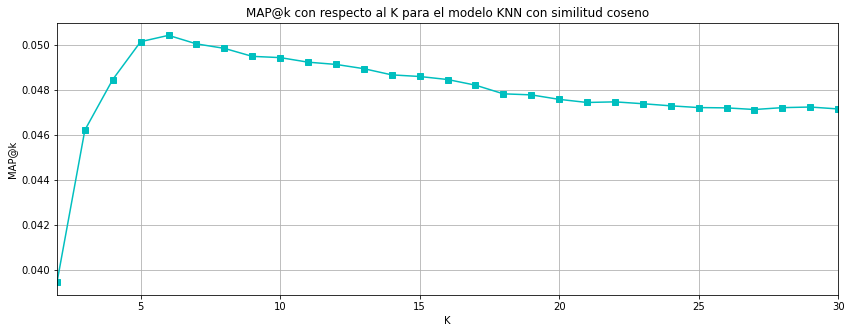

In [14]:
plt.figure(figsize=(14,5))
plt.title('MAP@k con respecto al K para el modelo KNN con similitud coseno')
plt.plot(Ks, metrica_2, 's-c')
plt.xlabel('K')
plt.ylabel('MAP@k')
plt.xlim(2,30)
plt.grid()

Vemos que valor mas adecuado para K es 6, por lo tanto instanciamos el modelo nuevamente

In [15]:
modelo2 = CosineRecommender(K=6)
modelo2.fit(train, show_progress=True)

In [16]:
r_2 = ranking_metrics_at_k(modelo2, train.T, test.T, K=20, show_progress=True)
print('el modelo KNN con similitud coseno tiene un valor de MAP@k igual a : %0.4f' % (r_2['map']))


el modelo KNN con similitud coseno tiene un valor de MAP@k igual a : 0.0504


#### Modelo # 3 KNN con medida de similitud BM25

El modelo de KNN con medida de similitud BM25 tiene 3 hiperparámetros (K es entero, K1 y B son reales), se desarrollará optimización bayesiana para obtener los mejores valores de estos. El modelo de optimización requiere el rango y la naturaleza del hiperparámetro. Se construye una función de evaluación que tomará los valores para estos hiperparámetros y obtiene un valor para la métrica. Ademas se generan condiciones de parada para detener la optimización, si se obtiene una diferencia en las métricas menor a 0.0015 o si se supera un tiempo de ejecución de 20 minutos.

Debemos tener en cuenta que el modelo de optimización busca la minimización de una función, pero debido a que la métrica utilizada busca ser maximizada y está entre 1 y 0, utilizamos (1 - métrica) para obtener un métrica análoga que sea minimizada

In [17]:
search_space3 = [Integer(1, 200, name='Ks'), 
                 Real(0, 10, name='K1s'), 
                 Real(0, 10, name='Bs')]

In [18]:
@use_named_args(search_space3)
def evaluate_model(Ks, K1s, Bs):
    modelo3 = BM25Recommender(K=Ks, K1=K1s, B=Bs)
    modelo3.fit(train, show_progress=False)
    r = ranking_metrics_at_k(modelo3, train.T, test.T, K=20, show_progress=False)
    return 1 - r['map']

In [19]:
callback1 = DeltaYStopper(delta=1.5e-3, n_best=5)
callback2 = DeadlineStopper(total_time=60*20)

In [20]:
%%time

optimization3 = gp_minimize(evaluate_model, search_space3, n_calls=200, callback=[callback1,callback2], random_state=42)

Wall time: 8min 55s


In [21]:
print('el modelo tiene un valor de MAP@k igual a : %0.5f' % (1- optimization3.fun))

el modelo tiene un valor de MAP@k igual a : 0.05738


In [22]:
print('Los hiperparámetros para el modelo optimizado son los siguiente')
print('K : ',optimization3.x[0])
print('K1 : ',optimization3.x[1])
print('B : ',optimization3.x[2])

Los hiperparámetros para el modelo optimizado son los siguiente
K :  200
K1 :  0.1156416989521357
B :  1.3906665653307289


A continuación se presenta el gráfico de convergencia para el procedimiento de optimización, en donde se indica para cada iteración el valor mínimo que ha tomado la métrica (1 - métrica), hasta converger. 

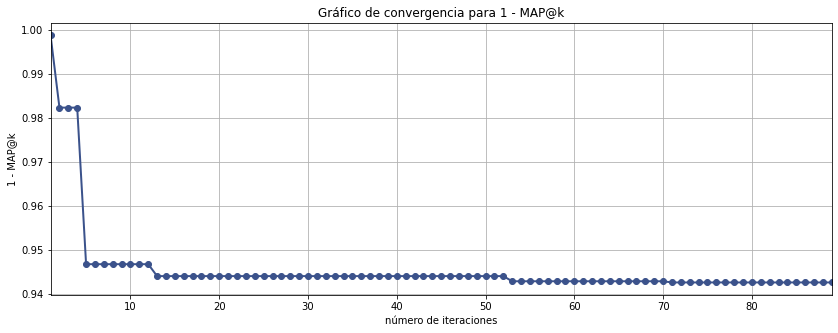

In [23]:
plt.figure(figsize=(14,5))
plot_convergence(optimization3)
plt.title('Gráfico de convergencia para 1 - MAP@k')
plt.xlabel('número de iteraciones')
plt.ylabel('1 - MAP@k')
plt.xlim(1,len(optimization3.func_vals))
plt.show()

Instanciamos nuevamente el modelo con los hiperparámetros obtenidos

In [24]:
modelo3 = BM25Recommender(K=200, K1=0.1156, B=1.3907)
modelo3.fit(train, show_progress=True)

In [25]:
r_3 = ranking_metrics_at_k(modelo3, train.T, test.T, K=20, show_progress=True)
print('el modelo KNN con similitud BM25 tiene un valor de MAP@k igual a : %0.4f' % (r_3['map']))


el modelo KNN con similitud BM25 tiene un valor de MAP@k igual a : 0.0574


#### Modelo # 4 ALS 

El modelo de mínimos cuadrados alternantes cuenta con 4 hiperparámetros (alpha, factor latente e iteraciones son enteros, regularización es real). De nuevo se desarrollará optimización bayesiana. 

Las condiciones de parada en este caso son por diferencia entre los resultados de las métricas (menor a 0.0015) o si supera un tiempo de ejecución de 5 horas (se considera un tiempo mucho mayor ya que cada iteración puede tomar mucho mas tiempo).

In [26]:
search_space4 = [Integer(5, 100, name='alfa'),
                 Integer(10, 400, name='fact'),
                 Real(10, 300, name='reg'),
                 Integer(20, 150, name='it')]

In [27]:
@use_named_args(search_space4)
def evaluate_model(alfa, fact, reg, it):
    trainALS, testALS = train_test_split(matrix_item_user * alfa, train_percentage=0.8)
    modelo4 = AlternatingLeastSquares(factors=fact, regularization=reg, iterations=it, random_state=42)
    modelo4.fit(trainALS, show_progress=False)
    r = ranking_metrics_at_k(modelo4, trainALS.T, testALS.T, K=20, show_progress=False)
    return 1 - r['map']

In [28]:
callback1 = DeltaYStopper(delta=1.5e-3, n_best=5)
callback2 = DeadlineStopper(total_time=60*60*5)

In [29]:
%%time

optimization4 = gp_minimize(evaluate_model, search_space4, n_calls=200, callback=[callback1,callback2], random_state=42)

Wall time: 2h 14min 51s


In [30]:
print('el modelo tiene un valor de MAP@k igual a : %0.5f' % (1- optimization4.fun))

el modelo tiene un valor de MAP@k igual a : 0.06582


In [31]:
print('Los hiperparámetros para el modelo optimizado son los siguiente')
print('alpha : ',optimization4.x[0])
print('factor latente : ',optimization4.x[1])
print('regularización : ',optimization4.x[2])
print('iteraciones : ',optimization4.x[3])

Los hiperparámetros para el modelo optimizado son los siguiente
alpha :  31
factor latente :  347
regularización :  251.37532269310853
iteraciones :  150


Los intervalos de los hiperparámetros se eligen para no hacer excesivo el tiempo de ejecución de cada iteración y permitirle al procedimiento de optimización contar con un buen número de iteraciones para ir ajustando los hiperparámetros. El elegir rangos mas extensos aumentaria considerablemente el tiempo de ejecución de cada iteración  lo que conlleva muy pocas iteraciones o tiempos de ejecución mucho mas extensos para la optimización. Es por ello que los resultados de los hiperparámetros se ubican en el extremo superior del rango para varios de ellos.

A continuación presentamos el gráfico de convergencia para este modelo. de igual manera que para el modelo anterior presenta el valor mínimo obtenido de 1 - métrica

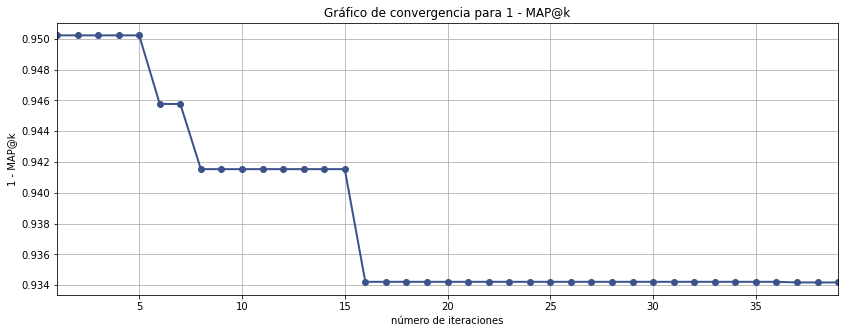

In [32]:
plt.figure(figsize=(14,5))
plot_convergence(optimization4)
plt.title('Gráfico de convergencia para 1 - MAP@k')
plt.xlabel('número de iteraciones')
plt.ylabel('1 - MAP@k')
plt.xlim(1,len(optimization4.func_vals))
plt.show()

Ahora instanciamos nuevamente el modelo con los mejores hiperparámetros obtenidos. Observemos como los tiempos de entrenamiento y evaluación son mucho mayores que para los modelos antes desarrollados.

In [39]:
alpha = 31
trainALS, testALS = train_test_split(matrix_item_user * alpha, train_percentage=0.8)

In [40]:
modelo4 = AlternatingLeastSquares(factors=347, regularization=251.3753, iterations=150, random_state=42)
modelo4.fit(trainALS, show_progress=True)

In [41]:
r_4 = ranking_metrics_at_k(modelo4, trainALS.T, testALS.T, K=20, show_progress=True)
print('el modelo ALS tiene un valor de MAP@k igual a : %0.4f' % (r_4['map']))


el modelo ALS tiene un valor de MAP@k igual a : 0.0655


#### Modelo # 5 basado en contenidos

Para el desarrollo de este modelo y a pesar de una exhaustiva revisión bibliográfica no se encontró una libreria que incopore un método que desarrolle propiamente el modelo, como si sucede con la libreria implicit para los modelos anteriores. Es por ello que hemos contruido una clase llamada BasedContent que incorpora los métodos fit() para entrenar el modelo y recomend() para generar las recomendaciones para un usuario específico, de manera similar a como funcionan los métodos contenidos en las librerias conocidas de sistemas de recomendación como implicit y surprise y lightFM. 

El algoritmo es instanciado a partir de la clase construida y cuenta con un hiperparámetro, que es el número de items vecinos a considerar (K). Este algoritmo funciona aplicando la similitud coseno a la matriz de caracteristicas de los items para de esa manera contruir una matriz de similitudes cuadrada que tiene tanto en filas como en columnas a los items y cuya diagonal será de 1 ya que cada item consigo mismo tiene similitud máxima. A partir de esta matriz se construye otra matriz donde se albergan los k vecinos mas similares para cada uno de los items. estos pasos se desarrollan en el método fit()

Con las matrices previamente cálculadas en el método anterior se ejecuta el método recommend() que no requiere propiamente la identificación del usuario, pero si la lista de juegos que dicho usuario posee, esto es porque este tipo de sistema de recomendación no interactua en ningun momento con la matriz de utilidad item - usuario si no que presenta recomendaciones basadas en similitud de items. Tambien requiere el número N de items recomendados y se puede elegir si filtrar o no los juegos que el usuario posee para la recomendación y si se separa la lista de juegos para desarrollar la validación cruzada, que es utilizada para el cálculo de la métrica. Este método contruye una matriz de similitud que contiene los K items vecinos a los jugados y un vector de usuario que contiene todos los items de la matriz mencionada y toma los valores de 1 o 0 segun posee o no el juego. Con estos se desarrolla el producto vectorial de ambos para contruir un score por item que es la sumatoria de las similitudes de cada item con respecto a los juegos previamente jugados y se divide por la sumatoria de las similitudes de cada item para normalizarse. Finalmente se retiran los items ya jugados por el usuario y se presentan las recomendaciones.

In [33]:
class ContentBased:
    
    def __init__(self, K):
        self.n_vecinos = K
    
    def fit(self, data_games_content):
        data_sparse = sparse.csr_matrix(data_games_content)
        similarities = cosine_similarity(data_sparse)
        similarity_matrix = pd.DataFrame(data=similarities, index= data_games_content.index, columns= data_games_content.index)
        
        for i in range (len(similarity_matrix)):
            similarity_matrix.iloc[i,i] = 1
        
        data_vecinos = pd.DataFrame(index=similarity_matrix.columns, columns=range(1,self.n_vecinos+1))
        for i in range(len(similarity_matrix.columns)):
            data_vecinos.iloc[i] = similarity_matrix.iloc[i].nlargest(self.n_vecinos).index
        
        self.similarity_matrix = similarity_matrix
        self.data_vecinos = data_vecinos
        
    def recommend(self, list_games, N=10, filter_games=True, cross_val=False):
        
        limite = int(len(list_games)*0.5)
        if cross_val == True:
            self.list_games_test = list_games[limite:]
            list_games = list_games[:limite]
                 
        items_mas_similares = self.data_vecinos.loc[list_games]
        similar_list = items_mas_similares.values.tolist()
        similar_list = [item for sublist in similar_list for item in sublist]
        similar_list = np.unique(similar_list).tolist()

        data_vecindad = self.similarity_matrix[similar_list].loc[similar_list]
        
        vector_usuario = []

        for i in data_vecindad.index:
            if i in list_games:
                vector_usuario.append(1)
            else:
                vector_usuario.append(0)
        
        score = np.dot(data_vecindad,vector_usuario)/data_vecindad.sum(axis=1)
        if filter_games == True:
            score.drop(list_games, inplace=True)
            
        recomendacion = score.nlargest(N)
        
        return recomendacion

Para el desarrollo de la métrica de evaluación, precisión media promedio a K items (MAP@k) se crea una función mapk que requiere el modelo previamente instanciado, la matriz de caracteristicas de los items, el parámetro K de items evaluados y una lista conformada por las listas de juegos que posee cada usuario segun su identificación de usuario, que va del 0 al 40747.

Para realizar la validación cruzada se toma la lista de juegos de cada jugador y se separa la mitad de los items que esta contiene para construir las recomendaciones. Luego se toma la otra mitad de los items de la lista de juegos y se evalua por medio de la métrica su presencia y posición dentro de las recomendaciones.

In [34]:
def mapk(modelo, data_games_content, lista_juegos_usuarios, K=10):
    
    modelo.fit(data_games_content)
    
    aveprecision_users = []
    for lista_juegos in lista_juegos_usuarios:
        
        recomendations = modelo.recommend(list_games=lista_juegos, N=K, filter_games=False, cross_val=True).index
        list_games_test = modelo.list_games_test
        
        contador_preferencias = 0
        precisiones = []
        for index, game in enumerate(recomendations):
            if game in list_games_test:
                contador_preferencias += 1
                precision = contador_preferencias/(index+1)
                precisiones.append(precision)
                
        if len(precisiones) != 0:
            aveprecision = np.mean(precisiones)
        else:
            aveprecision = 0
            
        aveprecision_users.append(aveprecision)
        
    mapk = np.mean(aveprecision_users)
    
    return mapk

finalmente para construir la lista arriba mencionada conformada por las listas de juegos que posee cada jugador definimos una función. Así cuando se requiere la lista de juegos de un jugador especifico se llama esta lista con el indice correspondiente a la identificación del usuario.

In [35]:
def lista_juegos_usuarios():
    
    lista_juegos = []
    for user in np.unique(data_reviews.user_id):
        lista_usuario = data_reviews.game_id[data_reviews.user_id == user].values.tolist()
        lista_juegos.append(lista_usuario)
        
    return lista_juegos

Con esto definido vamos a desarrollar la optimización del hiperparámetro K del algoritmo, esto lo haremos por medio de una iteración definida a lo largo de dicho hiperparámetro.

In [36]:
lista_juegos_usuarios = lista_juegos_usuarios()

In [37]:
%%time

Ks = [10,20,30,40,50,60,70]
metrica_5 = []

for K in Ks:
    modelo5 = ContentBased(K=K)
    r = mapk(modelo5, data_games_content, lista_juegos_usuarios, K=20)
    metrica_5.append(r)

Wall time: 3h 17min 43s


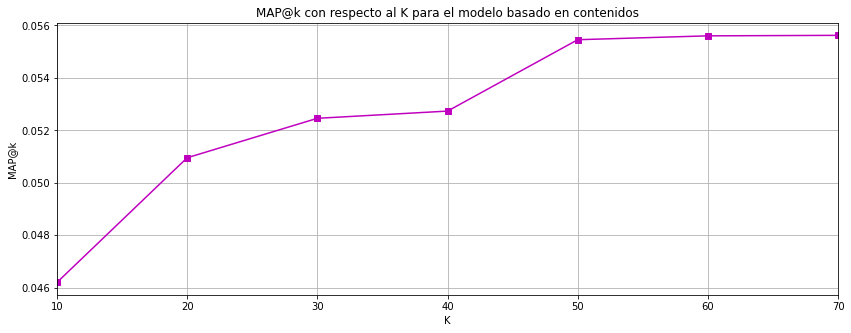

In [38]:
plt.figure(figsize=(14,5))
plt.title('MAP@k con respecto al K para el modelo basado en contenidos')
plt.plot(Ks, metrica_5, 's-m')
plt.xlabel('K')
plt.ylabel('MAP@k')
plt.xlim(10,70)
plt.grid()

Podemos ver que para valores mayores a 50, el hiperparámetro K no tiene un aumento sustancial en el desempeño del modelo, por lo tanto instanciamos nuevamente el modelo ajustando este hiperparámetro a 50.

In [42]:
modelo5 = ContentBased(K=50)
modelo5.fit(data_games_content)

In [43]:
%%time

r_5 = mapk(modelo5, data_games_content, lista_juegos_usuarios, K=20)
print('el modelo basado en contenidos tiene un valor de MAP@k igual a : %0.4f' % (r_5))

el modelo basado en contenidos tiene un valor de MAP@k igual a : 0.0555
Wall time: 34min 17s


#### Comparativo de los resultados obtenidos

A continuación presentamos una tabla con los resultados de la métrica de evaluación para cada uno de los modelos planteados

In [44]:
Comparativo = {'Caso benchmark' : r_1['map'],
               'KNN con similitud coseno' : r_2['map'],
               'KNN con similitud BM25' : r_3['map'],
               'ALS' : r_4['map'],
               'Basado en contenidos' : r_5}

Comparativo = pd.DataFrame.from_dict(Comparativo, orient='index',columns=['map'])

In [45]:
print('Comparativo de los modelos segun su desempeño en la métrica MAP@k : \n')
print(Comparativo.map.sort_values(ascending=False))

Comparativo de los modelos segun su desempeño en la métrica MAP@k : 

ALS                         0.065455
KNN con similitud BM25      0.057390
Basado en contenidos        0.055457
KNN con similitud coseno    0.050416
Caso benchmark              0.028603
Name: map, dtype: float64


Vemos que el algoritmo de filtro colaborativo basado en modelo , de mínimos cuadrados alternantes, es el que presenta mejores resultados.

#### Desarrollo de las predicciones con el modelo ALS

Elegiremos un usuario al azar y realizaremos algunas predicciones, tales como las recomendaciones que se le sugieren, la explicación de la recomendación principal, los items mas similares a la recomendación principal y los usuarios mas similares al usuario elegido

In [46]:
user = 33706
usuario = np.unique(data_reviews.username[data_reviews.user_id == user])[0]
juegos_usuario = list(map(dict(zip(data_games.game_id,data_games.title)).get,lista_juegos_usuarios[user]))

Solicitamos las 20 recomendaciones principales para el usuario. Debemos proporcionar al método la lista de juegos que el usuario ya posee para que los elimine de las recomendaciones

In [47]:
recommended = modelo4.recommend(userid=user, user_items=matrix_user_item, N=20, filter_items=lista_juegos_usuarios[user])

games_recom = [i[0] for i in recommended]
scores_recom = [i[1] for i in recommended]

recom = pd.Series(scores_recom, index = games_recom)
recom.index = recom.index.map(dict(zip(data_games.game_id,data_games.title)))

In [48]:
print('Usuario : ', usuario,'\n')
print('Juegos del Usuario :\n')
print(juegos_usuario,'\n')
print('Recomendaciones por similitud:\n')
print(recom)

Usuario :  andyfinn2012 

Juegos del Usuario :

['Batman™: Arkham Origins Blackgate - Deluxe Edition', 'DC Universe™ Online', 'The Ship: Murder Party', 'Kingdom Rush', 'Reus', 'Rocketbirds: Hardboiled Chicken', 'LEGO The Lord of the Rings', 'STAR WARS™ Knights of the Old Republic™ II - The Sith Lords™', 'STAR WARS™ Empire at War - Gold Pack', "Zombie Tycoon 2: Brainhov's Revenge", 'PAYDAY™ The Heist', 'STAR WARS™ - Knights of the Old Republic™', 'HELLDIVERS™', 'Risk of Rain', 'LEGO® Marvel™ Super Heroes', 'Battlefield: Bad Company™ 2', 'STAR WARS™ Republic Commando™'] 

Recomendaciones por similitud:

Batman™: Arkham Origins                                    0.579219
Star Wars: Battlefront 2 (Classic, 2005)                   0.470422
Batman™: Arkham Knight                                     0.357619
LEGO® Batman™3: Beyond Gotham                              0.352306
STAR WARS™ Jedi Knight - Jedi Academy™                     0.334010
LEGO® Star Wars™ - The Complete Saga               

Vemos que los juegos que posee el usuario en su plataforma son principalmente del género superheroes y ciencia ficción, acorde a las recomendaciones que le genera el modelo que en los primero lugares ubica varios juegos del Batman y STAR WARS

Ahora veamos la explicación del principal juego recomendado

In [49]:
explicacion = modelo4.explain(userid=user, user_items=matrix_user_item, itemid=games_recom[0], N=10)

games_explain = [i[0] for i in explicacion[1]]
scores_explain = [i[1] for i in explicacion[1]]

explain = pd.Series(scores_explain, index = games_explain)
explain.index = explain.index.map(dict(zip(data_games.game_id,data_games.title)))

In [50]:
print('Recomendación Top : ', recom.index[0],'\n')
print('Explicacion de la recomendación Top: \n')
print(explain)

Recomendación Top :  Batman™: Arkham Origins 

Explicacion de la recomendación Top: 

Batman™: Arkham Origins Blackgate - Deluxe Edition              0.009473
DC Universe™ Online                                             0.006915
LEGO® Marvel™ Super Heroes                                      0.006281
STAR WARS™ Empire at War - Gold Pack                            0.004891
LEGO The Lord of the Rings                                      0.004114
PAYDAY™ The Heist                                               0.003240
Battlefield: Bad Company™ 2                                     0.002803
STAR WARS™ Knights of the Old Republic™ II - The Sith Lords™    0.002531
STAR WARS™ - Knights of the Old Republic™                       0.002022
STAR WARS™ Republic Commando™                                   0.001872
dtype: float64


Como podemos ver el juego Arkham Origins fue recomendado debido a la similitud que tiene con varios juegos de Superheroes que ya posee el jugador, uno de ellos una version especial del propio Arkham Origins 

Busqueda de los juegos mas similares al principal juego recomendado

In [51]:
item_similar = modelo4.similar_items(itemid=games_recom[0], N=10)

games_itemsim = [i[0] for i in item_similar]
scores_itemsim = [i[1] for i in item_similar]

item_sim = pd.Series(scores_itemsim, index = games_itemsim)
item_sim.index = item_sim.index.map(dict(zip(data_games.game_id,data_games.title)))

In [52]:
print('Item elegido : ',recom.index[0],'\n')
print('Items mas similares : \n')
print(item_sim)

Item elegido :  Batman™: Arkham Origins 

Items mas similares : 

Batman™: Arkham Origins                               1.000000
Batman: Arkham Asylum Game of the Year Edition        0.513631
Batman™: Arkham Origins Blackgate - Deluxe Edition    0.485518
Batman™: Arkham Knight                                0.458772
Batman: Arkham City - Game of the Year Edition        0.359471
Assassin's Creed Freedom Cry                          0.279052
Catzilla 4K - Advanced                                0.275399
Assassin’s Creed® III                                 0.263148
LEGO® Batman 2 DC Super Heroes™                       0.262272
Batman - The Telltale Series                          0.257684
dtype: float64


Busqueda de los usuarios mas similares al usuario elegido

In [53]:
user_similar = modelo4.similar_users(userid=user, N=10)

users_usersim = [i[0] for i in user_similar]
scores_usersim = [i[1] for i in user_similar]

usersim = pd.Series(scores_usersim, index = users_usersim)
usersim.index = usersim.index.map(dict(zip(data_reviews.user_id,data_reviews.username)))

In [54]:
print('Usuario elegido : ',usuario,'\n')
print('Usuarios mas similares : \n')
print(usersim)

Usuario elegido :  andyfinn2012 

Usuarios mas similares : 

andyfinn2012                   1.000000
DeyQuan                        0.385220
Yes                            0.382669
Kanan-Jarrus3244(BMGHunt3r)    0.369993
Koodlevoodlen                  0.368166
add2Kart                       0.366813
Admiral Allahu Ackbar          0.366025
AutomaticRogue                 0.362267
Dexter <3                      0.359896
Geoff Shen                     0.358736
dtype: float64
